# Figure 3b Reproduction Notebook

This notebook reproduces Fig3b from pre-generated CSV data files. 

## 1. Setup and Helper Functions

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy import stats
from statsmodels.stats.multitest import multipletests
from matplotlib.patches import Patch

def apply_matplotlib_settings(width_mm, height_mm):
    """
    Applies consistent matplotlib settings for publication-quality plots.
    Converts dimensions from mm to inches for figsize.
    """
    mm_to_inch = 1 / 25.4
    
    settings = {
        "text.usetex": False,
        "mathtext.default": "regular",
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans", "Arial", "sans-serif"],
        "font.size": 7,
        "figure.titlesize": 7,
        "legend.fontsize": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.7,
        "xtick.major.width": 0.7,
        "ytick.major.width": 0.7,
        "lines.linewidth": 1.5,
        "lines.markersize": 3,
        "savefig.dpi": 300,
        "figure.dpi": 150,
        "savefig.format": "pdf",
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.1,
        "svg.fonttype": "none",
        "legend.frameon": False,
        "pdf.fonttype": 42,
        "figure.figsize": (width_mm * mm_to_inch, height_mm * mm_to_inch),
    }
    plt.rcParams.update(settings)

def get_performance_based_order(df, category_col):
    """
    Calculates the order of categories based on descending median performance.
    Sorts based on the 'finetuned_roc_auc' column (the "All" metric).
    """
    if df is None or df.empty or category_col not in df.columns:
        return []
    
    median_perf = df.groupby(category_col)['finetuned_roc_auc'].median()
    sorted_categories = median_perf.sort_values(ascending=False).index.tolist()
    print(f"Plot order for '{category_col}' based on median performance: {sorted_categories}")
    return sorted_categories

def perform_statistical_tests(data_df, category_col, comparison_type):
    """
    Performs one-sided paired t-tests with Benjamini-Hochberg correction.
    Returns a dictionary with significance results for each category.
    """
    if data_df is None or data_df.empty:
        return {}
    
    categories = data_df[category_col].unique()
    
    if comparison_type == 'model':
        ref_category = 'PRIME'
        test_direction = 'greater'
    elif comparison_type == 'config':
        ref_category = 'CFT'
        test_direction = 'greater'
    elif comparison_type == 'calibration':
        ref_category = '100 Trials'
        test_direction = 'less'
    elif comparison_type == 'window_size':
        ref_category = '50 ms'
        test_direction = 'greater'
    elif comparison_type == 'window_location':
        ref_category = '10 ms'
        test_direction = 'greater'
    else:
        return {}
    
    if ref_category not in categories:
        print(f"Warning: Reference category '{ref_category}' not found in data")
        return {}
    
    ref_data_all = data_df[data_df[category_col] == ref_category]['finetuned_roc_auc'].values
    ref_data_extreme = data_df[data_df[category_col] == ref_category]['finetuned_roc_auc_extreme'].values
    
    p_values = []
    test_results = {}
    
    for category in categories:
        if category == ref_category:
            test_results[category] = {'all': 0, 'extreme': 0}
            continue
            
        cat_data_all = data_df[data_df[category_col] == category]['finetuned_roc_auc'].values
        cat_data_extreme = data_df[data_df[category_col] == category]['finetuned_roc_auc_extreme'].values
        
        if len(cat_data_all) != len(ref_data_all) or len(cat_data_extreme) != len(ref_data_extreme):
            print(f"Warning: Sample sizes don't match for {category}. Using available data.")
            min_len_all = min(len(cat_data_all), len(ref_data_all))
            min_len_extreme = min(len(cat_data_extreme), len(ref_data_extreme))
            cat_data_all = cat_data_all[:min_len_all]
            ref_data_all_paired = ref_data_all[:min_len_all]
            cat_data_extreme = cat_data_extreme[:min_len_extreme]
            ref_data_extreme_paired = ref_data_extreme[:min_len_extreme]
        else:
            ref_data_all_paired = ref_data_all
            ref_data_extreme_paired = ref_data_extreme
        
        if test_direction == 'greater':
            _, p_all = stats.ttest_rel(ref_data_all_paired, cat_data_all, alternative='greater')
            _, p_extreme = stats.ttest_rel(ref_data_extreme_paired, cat_data_extreme, alternative='greater')
        else:
            _, p_all = stats.ttest_rel(ref_data_all_paired, cat_data_all, alternative='less')
            _, p_extreme = stats.ttest_rel(ref_data_extreme_paired, cat_data_extreme, alternative='less')
        
        p_values.extend([p_all, p_extreme])
        test_results[category] = {'all': p_all, 'extreme': p_extreme}
    
    if p_values:
        rejected, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')
        
        p_idx = 0
        for category in categories:
            if category == ref_category:
                continue
            test_results[category]['all_corrected'] = p_corrected[p_idx]
            test_results[category]['extreme_corrected'] = p_corrected[p_idx + 1]
            p_idx += 2
    
    return test_results

def get_significance_stars(p_value):
    """Convert p-value to significance stars."""
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

def darken_color(hex_color, factor=0.7):
    """Darken a hex color by the given factor"""
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    darkened_rgb = tuple(int(c * factor) for c in rgb)
    return f"#{darkened_rgb[0]:02x}{darkened_rgb[1]:02x}{darkened_rgb[2]:02x}"

def create_comparison_violin_plot(data_df, category_col, category_order, comparison_type, y_label, output_filename):
    """Generates and saves a layered violin and box plot."""
    if data_df is None or data_df.empty:
        print(f"Cannot create plot '{output_filename}': Input DataFrame is empty.")
        return

    if comparison_type == 'model':
        ref_category = 'PRIME'
    elif comparison_type == 'config':
        ref_category = 'CFT'
    elif comparison_type == 'calibration':
        ref_category = '100 Trials'
    elif comparison_type == 'window_size':
        ref_category = '50 ms'
    elif comparison_type == 'window_location':
        ref_category = '10 ms'
    else:
        ref_category = category_order[0] if category_order else None

    colors_all = {}
    colors_extreme = {}
    for cat in category_order:
        if cat == ref_category:
            colors_all[cat] = '#80a687'
            colors_extreme[cat] = '#cee1d1'
        else:
            colors_all[cat] = '#9e9e9e'
            colors_extreme[cat] = '#e1e1e0'

    stat_results = perform_statistical_tests(data_df, category_col, comparison_type)

    df_long = data_df.melt(
        id_vars=['subject_id', category_col],
        value_vars=['finetuned_roc_auc', 'finetuned_roc_auc_extreme'],
        var_name='metric',
        value_name='roc_auc'
    )
    df_long['variant'] = np.where(df_long['metric'].str.contains('_extreme'), 'Extreme', 'All')
    df_long['cat_variant'] = df_long[category_col].astype(str) + '_' + df_long['variant']
    df_long[category_col] = pd.Categorical(df_long[category_col], categories=category_order, ordered=True)
    plot_order = [f'{c}_{v}' for c in category_order for v in ['All', 'Extreme']]

    position_mapping = {}
    current_pos = 0
    for i, c in enumerate(category_order):
        position_mapping[f'{c}_All'] = current_pos
        position_mapping[f'{c}_Extreme'] = current_pos + 0.4
        current_pos += 1.5

    palette_dict = {}
    edge_palette_dict = {}
    for c in category_order:
        palette_dict[f'{c}_All'] = colors_all.get(c, '#333333')
        palette_dict[f'{c}_Extreme'] = colors_extreme.get(c, '#CCCCCC')
        edge_palette_dict[f'{c}_All'] = darken_color(colors_all.get(c, '#333333'))
        edge_palette_dict[f'{c}_Extreme'] = darken_color(colors_extreme.get(c, '#CCCCCC'))

    fig, ax = plt.subplots()

    for cat_var in plot_order:
        data_subset = df_long[df_long['cat_variant'] == cat_var]
        if data_subset.empty:
            continue
        
        pos = position_mapping[cat_var]
        color = palette_dict.get(cat_var, '#333333')
        edge_color = edge_palette_dict.get(cat_var, '#333333')
        
        parts = ax.violinplot(
            dataset=data_subset['roc_auc'].dropna(),
            positions=[pos],
            showmeans=False, showmedians=False, showextrema=False,
            widths=0.4, bw_method=0.2
        )
        
        for pc in parts['bodies']:
            pc.set_facecolor(color)
            pc.set_edgecolor(edge_color)
            pc.set_linewidth(0.5)
            pc.set_alpha(1.0)
            pc.set_zorder(1)

    for cat_var in plot_order:
        data_subset = df_long[df_long['cat_variant'] == cat_var]
        box_data = data_subset['roc_auc'].dropna()
        if box_data.empty:
            continue

        edge_color = edge_palette_dict.get(cat_var, 'gray')
        box_pos = position_mapping[cat_var]

        bp = ax.boxplot(
            x=box_data, positions=[box_pos], vert=True, patch_artist=True, widths=0.2,
            showfliers=False,
            whiskerprops={'color': edge_color, 'linewidth': 0.5, 'zorder': 2},
            capprops={'color': edge_color, 'linewidth': 0.5, 'zorder': 2},
            medianprops={'color': edge_color, 'linewidth': 0.8, 'zorder': 4},
        )
        for patch in bp['boxes']:
            patch.set_facecolor('w')
            patch.set_edgecolor(edge_color)
            patch.set_linewidth(0.5)
            patch.set_zorder(3)

    y_max = ax.get_ylim()[1]
    star_offset = 0.02
    
    for cat_var in plot_order:
        condition = cat_var.split('_')[0]
        if len(cat_var.split('_')) > 2:
            condition = '_'.join(cat_var.split('_')[:-1])
        
        variant = cat_var.split('_')[-1]
        pos = position_mapping[cat_var]
        
        if condition in stat_results:
            if variant == 'All' and 'all_corrected' in stat_results[condition]:
                stars = get_significance_stars(stat_results[condition]['all_corrected'])
            elif variant == 'Extreme' and 'extreme_corrected' in stat_results[condition]:
                stars = get_significance_stars(stat_results[condition]['extreme_corrected'])
            else:
                stars = ''
            
            if stars:
                ax.text(pos, y_max - star_offset, stars, 
                       ha='center', va='top', fontsize=6, fontweight='bold',
                       zorder=5)

    tick_positions = [i * 1.5 + 0.2 for i in range(len(category_order))]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(category_order, rotation=45, ha="right")
    ax.tick_params(axis='x', length=3)
    ax.set_xlabel('')

    legend_elements = [
        Patch(facecolor='#555555', label='All'),
        Patch(facecolor='#CCCCCC', label='Extreme')
    ]
    ax.legend(handles=legend_elements, loc='lower right', handlelength=1)

    ax.axhline(0.5, color='gray', linestyle=':', linewidth=1)
    ax.set_ylabel(y_label)
    ax.set_ylim(0.4, 1.0)

    fig.tight_layout(pad=0.5)
    plt.savefig(output_filename)
    print(f"\n✅ Plot saved successfully to {output_filename}")
    
    print(f"Statistical test results for {comparison_type}:")
    for category, results in stat_results.items():
        if 'all_corrected' in results:
            print(f"  {category}: All p={results['all_corrected']:.4f}, Extreme p={results['extreme_corrected']:.4f}")

## 2. Model Comparison Plot

Plot order for 'model' based on median performance: ['PRIME', 'PRIME\nw/ Conv', 'Shallow\nConvNet', 'Deep\nConvNet', 'PRIME\nw/o S4', 'EEGNet', 'ATCNet']

✅ Plot saved successfully to prime_vs_others_violin_plot.pdf
Statistical test results for model:
  EEGNet: All p=0.0000, Extreme p=0.0000
  Deep
ConvNet: All p=0.0000, Extreme p=0.0000
  ATCNet: All p=0.0000, Extreme p=0.0000
  Shallow
ConvNet: All p=0.0000, Extreme p=0.0000
  PRIME
w/o S4: All p=0.0000, Extreme p=0.0000
  PRIME
w/ Conv: All p=0.0000, Extreme p=0.0000


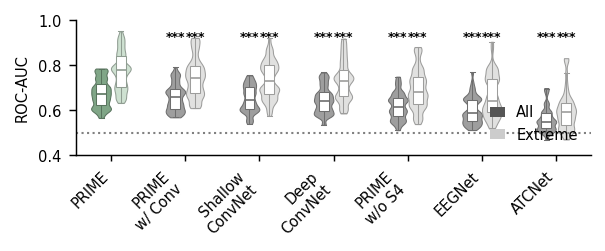

In [8]:
FIG_DIMS = {'width': 100, 'height': 40}

# Load data from CSV
df_models = pd.read_csv('model_comparison_data.csv')

# Set plot styles
apply_matplotlib_settings(FIG_DIMS['width'], FIG_DIMS['height'])

# Determine plot order based on performance
model_plot_order = get_performance_based_order(df_models, 'model')
if not model_plot_order:
    model_plot_order = list(df_models['model'].unique()) # Fallback

# Create and save the plot
create_comparison_violin_plot(df_models, 'model', model_plot_order, 'model', 'ROC-AUC', "prime_vs_others_violin_plot.pdf")